In [1]:
#modules
import os
import random
import sys
import time

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import abs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Task 01
(10pt) Wykonaj zadanie 2 z listy 6 z wykorzystaniem Kerasa i Tensorflow. Wykonaj testy dla kilku funkcji aktywacji oraz dla wielu warstw sieci. Poeksperymentuj!

#### Eksperymenty
Jako eksperymenty zaimplementowałem po prostu algorytm metaheurystyczny local search( hill climbing, tylko po mojemu) na podstawie
zadanego rozwiązania znajduje/ tworzy sieci o minimalnym mse. W poniższym mamy więc tworzenie modelu, z wykresem najlepszego z przeglądanych, ale bez animacji.
Animacja dla jednej z wybranych sieci (scroll down).
Z ograniczeniem do maksymalnie 10 warstw i 10 neuronów w layer.

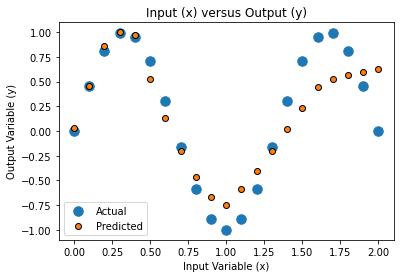

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 16        
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 35        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 8         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
[dense_24 tanh]
[dense_25 relu]
[dense_26 tanh]
[dense_27 linear]

 min mse model= 0.07489187827551086


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
def plot_(x, y, scx, scy, model):
    yhat = model.predict(x)
    x_plot = scx.inverse_transform(x)
    y_plot = scy.inverse_transform(y)
    yhat_plot = scy.inverse_transform(yhat)
    pyplot.scatter(x_plot, y_plot, label='Actual', s=90)
    pyplot.scatter(x_plot, yhat_plot, label='Predicted', edgecolors='black')
    pyplot.title('Input (x) versus Output (y)')
    pyplot.xlabel('Input Variable (x)')
    pyplot.ylabel('Output Variable (y)')
    pyplot.legend()
    pyplot.show()


def get_random_model(x, y, ep=500, acts=('tanh', 'relu', 'sigmoid'), krnl_init='he_uniform', in_dim=1, out_dim=1,
                     max_neuron_layer=10,
                     min_neuron_layer=2, layers_number=random.randint(1, 7), ls='mse', opt='adam'):
    model = Sequential()
    model.add(
        Dense(random.randint(min_neuron_layer, max_neuron_layer), input_dim=in_dim, activation=random.choice(acts),
              kernel_initializer=krnl_init))
    for i in range(layers_number):
        neurons = random.randint(min_neuron_layer, max_neuron_layer)
        model.add(
            Dense(neurons, activation=random.choice(acts),
                  kernel_initializer=krnl_init))
    model.add(Dense(out_dim))
    model.compile(loss=ls, optimizer=opt)
    model.fit(x, y, epochs=ep, batch_size=10, verbose=0)
    return model


def get_data(name):
    if 'parabolic' in name:
        x = np.linspace(-50, 50, 26)
        y = x ** 2
    elif 'sinus' in name:
        x = np.linspace(0, 2, 21)
        y = np.sin((3 * np.pi / 2) * x)
    else:
        raise NotImplementedError
    x = x.reshape((len(x), 1))
    y = y.reshape((len(y), 1))
    scale_x = MinMaxScaler()
    x = scale_x.fit_transform(x)
    scale_y = MinMaxScaler()
    y = scale_y.fit_transform(y)
    return x, y, scale_x, scale_y


def learn_parabolic(model):
    x, y, scx, scy = get_data('learn_parabolic')
    yhat = model.predict(x)
    y_plot = scy.inverse_transform(y)
    yhat_plot = scy.inverse_transform(yhat)
    #print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
    return mean_squared_error(y_plot, yhat_plot)


def learn_sinus(model):
    x, y, scx, scy = get_data('learn_sinus')
    yhat = model.predict(x)
    y_plot = scy.inverse_transform(y)
    yhat_plot = scy.inverse_transform(yhat)
    #print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
    return mean_squared_error(y_plot, yhat_plot)


def get_current_time():
    return int(round(time.time() * 1000))


def get_environment(x, y, n=10):
    return [get_random_model(x, y) for _ in range(n)]


def local_search(t, quality):
    end_time = get_current_time() + t * 1000
    x, y, scx, scy = get_data(quality.__name__)
    model = get_random_model(x, y)
    best_solution = model
    while get_current_time() < end_time:
        model = min(get_environment(x, y), key=quality)
        if quality(model) < quality(best_solution):
            best_solution = model
    plot_(x, y, scx, scy, best_solution)
    return best_solution


def main(t, func):
    mod_best = local_search(t, quality=func)
    print(mod_best.summary())
    for layer in mod_best.layers:
        print('['+layer.name, str(layer.activation).split(" ")[1]+']')
    print('\n min mse model=',func(mod_best))

# for example
main(20, learn_sinus)

### Tutaj przykładowe ładne modele z aktywacjami dobranymi przez powyższy local search

#### Multiple Layer

##### Parabolic (multiple layer)

MSE: 2864.313


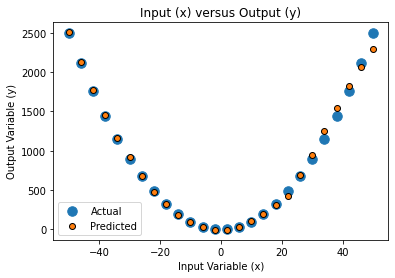

In [3]:
x = np.linspace(-50, 50, 26)
y = x ** 2
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(3, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()


##### Sinus(multiple layer)

MSE: 0.153


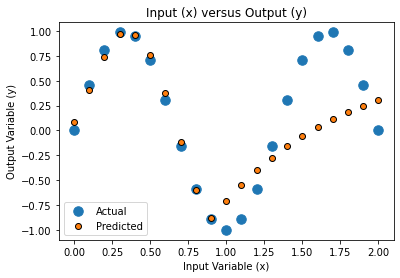

In [4]:

x = np.linspace(0, 2, 21)
y = np.sin((3 * np.pi / 2) * x)
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(4, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(7, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

### 2 layer

##### Parabolic (1-x-1)

MSE: 314708.369


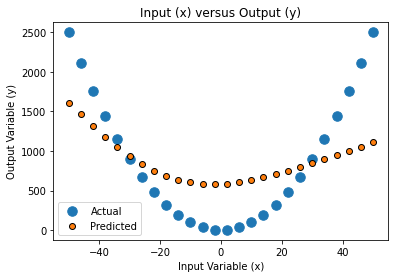

In [5]:
x = np.linspace(-50, 50, 26)
y = x ** 2
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(8, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

##### Sinus(1-x-1)

MSE: 0.391


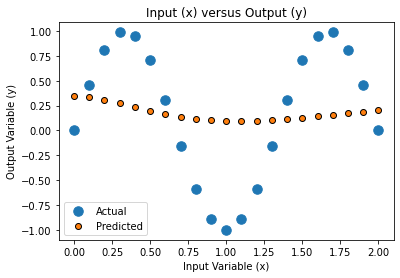

In [6]:
x = np.linspace(0, 2, 21)
y = np.sin((3 * np.pi / 2) * x)
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(10, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

Jak widać sieci wielowarstwowe radzą sobie znacznie lepiej.

### Task 02
(15pt) Wykorzystując architekturę sieci neuronowych RetinaNet Focal Loss for Dense Object Detection zaprogramuj wykrywanie obiektów. Możesz np. skorzystać z implementacji sieci w Kerasie razem z modelem uczonym na danych COCO object detection dataset.

In [7]:
# labels names
labels_to_names  = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
    5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
    10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
    14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
    20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
    30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite',
    34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard',
    37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
    41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl',
    46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli',
    51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
    56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
    60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse',
    65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
    69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book',
    74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
    78: 'hair drier', 79: 'toothbrush'} 

Using TensorFlow backend.
/home/piotr/Documents/python-course/List07/venv/lib/python3.8/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

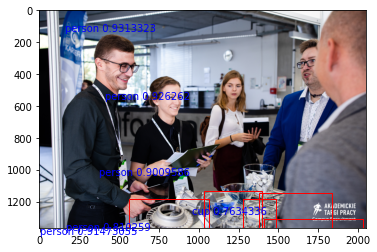

In [8]:
model_path = 'resnet50_coco_best_v2.1.0.h5'
model = models.load_model(model_path, backbone_name='resnet50')
filename = 'images/atp.jpg'
output_file = 'cords'
try:
    file = open(output_file, 'w')
except FileNotFoundError:
    sys.stderr.write('File not found')
    sys.exit(0)
image = read_image_bgr(filename)
image = preprocess_image(image)
(image, scale) = resize_image(image)
image = np.expand_dims(image, axis=0)

(boxes, scores, labels) = model.predict_on_batch(image)
boxes /= scale
im = np.array(Image.open(filename), dtype=np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(im)
for (box, score, label) in zip(boxes[0], scores[0], labels[0]):
        if score < 0.7:
            continue
        box = box.astype("int")
        row = " ".join([labels_to_names[label], str(score),
                        str(box[0]), str(box[1]), str(box[2]), str(box[3])])
                        #box 0 X LEWA Y1 X2 y2
        print(row)
        #xy lewy dolny width height
        rect = patches.Rectangle((box[0],box[3]),abs(box[2]-box[0]),abs(box[3]-box[1]),linewidth=1,edgecolor='r'
                                 ,facecolor='none',label='Label')
        ax.add_patch(rect)
        plt.text(box[1],box[0],labels_to_names[label]+' '+str(score),color='blue')
        file.write("{}\n".format(row))
file.close()
plt.show()